In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
df = pd.DataFrame(california.data, columns = california.feature_names)
df["Target"] = california.target

# 학습코드 구현
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


## 데이터 분할 설정

In [104]:
# 여기서는 분할 비율만 설정
# 실제 데이터 분할은 랜덤하게 섞은 다음에 split()로 나눔

ratio = [.6,.2,.2]
train_cnt = int(data.size(0)*ratio[0])
valid_cnt = int(data.size(0)*ratio[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


## 데이터 랜덤화 분할

In [105]:
indices = torch.randperm(data.size(0))
x = torch.index_select(x,dim=0,index=indices)
y = torch.index_select(y,dim=0,index=indices)

x = list(x.split(cnts,dim=0))
y = y.split(cnts,dim=0)

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


## 데이터 정규화

In [106]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

## 학습 코드 구현

In [107]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

optimizer = optim.Adam(model.parameters())

In [108]:
# 하이퍼 파라미터
n_epochs = 4000
batch_size = 256
print_interval = 100

In [116]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [127]:
train_history, valid_history = [],[]

import time
start = time.time()
for i in range(n_epochs):
    #shuffles
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_,y_): # iteration : 12,384 // 256 + 1 = 49 
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # 메모리 손실을 없애기 위해

        # y_hat += [y_hat_i]

    train_loss = train_loss / len(x_)

    with torch.no_grad(): # 계산 그래프 생성을 하지 않음 (forward만 하고 backward는 하지 않음)
        # shuffle 과정 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_,y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_) # 1epoch 당 평균 손실값(검증)

    # 손실곡선을 그리기 위해 손실 값 저장
    train_history += [train_loss] # epoch 마다 학습 솔실 값 차례로 저장
    valid_history += [valid_loss] # epoch 마다 학습 솔실 값 차례로 저장

    # 출력
    if(i+1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec' % (
            (i+1), n_epochs,
            train_loss,
            valid_loss,
            lowest_loss,
            time.time() - start
        ))
        start = time.time()

    # 검증 손실의 최소값 찾기
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict()) # 최소손실일 때 모델을 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' % early_stop)
            break
            
# 학습 종료 후
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model) # 최소 손실 모델로 복귀

Epoch 100/4000: train_loss=0.3057 valid_loss=0.3207 lowest_loss=0.3193 elapsed_time=1.06sec
Epoch 200/4000: train_loss=0.3062 valid_loss=0.3205 lowest_loss=0.3192 elapsed_time=1.03sec
There is no improvement during last 100 epochs.
The best validation loss from epoch 127 : 3.1922e-01


<All keys matched successfully>

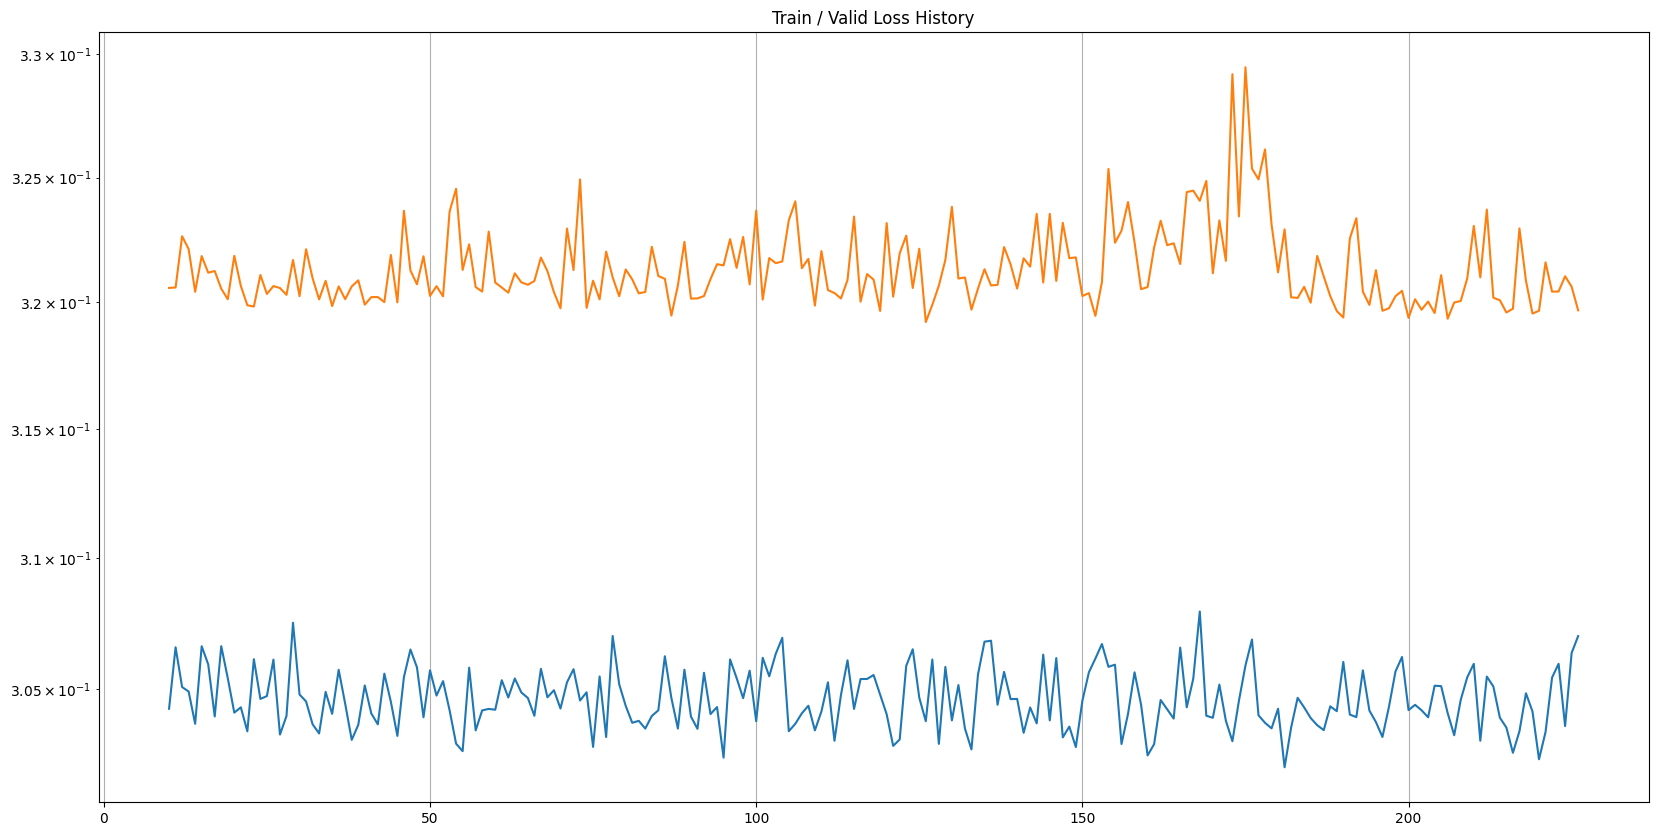

In [128]:
# 손실곡선 확인

plot_from = 10

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## 결과 확인